In [ ]:
import numpy as np  
import pandas as pd  

import pickle
import matplotlib.pyplot as plt  

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score

from tqdm import tqdm
import shap 
import lime
import lime.lime_tabular


from keras.models import Sequential
#from keras.layers import BatchNormalization
from keras.layers import Dense, Dropout
#from tensorflow.keras.optimizers import SGD, Adam, Adadelta
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import joblib


shap.initjs()


/Users/martinkatona/Desktop/DP/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
df = pd.read_csv("../../diabetes_data.csv")


# Print the original columns
print("Original Columns:", df.columns)

# List of columns to keep


columns_to_keep = ['Age', 'Sex', 'HighChol', 'CholCheck', 'BMI', 'Smoker','HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies','HvyAlcoholConsump', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk','Stroke', 'HighBP', 'Diabetes'] 

# Select only the columns to keep
df = df[columns_to_keep]

# Print the updated columns
print("Columns after keeping specified ones:", df.columns)


# Identify categorical and numerical columns
categorical_cols = ['Sex', 'HighChol', 'CholCheck', 'Smoker', 'HeartDiseaseorAttack',
                    'PhysActivity',  'HvyAlcoholConsmp', 'DiffWalk', 'Stroke', 'HighBP','Fruits'] #removed Fruits and Veggies
ordinal_cols = ['Age', 'GenHlth']
numerical_cols = ['BMI', 'MentHlth', 'PhysHlth']


# Filter column type lists based on columns_to_keep
categorical_cols = [col for col in categorical_cols if col in columns_to_keep]
ordinal_cols = [col for col in ordinal_cols if col in columns_to_keep]
numerical_cols = [col for col in numerical_cols if col in columns_to_keep]


print("Categorical Columns:", categorical_cols)
print("Ordinal Columns:", ordinal_cols)
print("Numerical Columns:", numerical_cols)


# Initialize scalers
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()


# Scale Ordinal Features
df[ordinal_cols] = minmax_scaler.fit_transform(df[ordinal_cols])

# Scale Numerical Features
df[numerical_cols] = standard_scaler.fit_transform(df[numerical_cols])

# Save the scalers
joblib.dump(minmax_scaler, 'dia_saved_models/minmax_scaler_all.pkl')
joblib.dump(standard_scaler, 'dia_saved_models/standard_scaler_all.pkl')


# Step 1: Prepare data
print("Preparing data...")
X = df.drop(['Diabetes'], axis=1)
y = df['Diabetes']

num_features = len(X.columns)
print(num_features)



Original Columns: Index(['Age', 'Sex', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk',
       'Stroke', 'HighBP', 'Diabetes'],
      dtype='object')
Columns after keeping specified ones: Index(['Age', 'Sex', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk',
       'Stroke', 'HighBP', 'Diabetes'],
      dtype='object')
Categorical Columns: ['Sex', 'HighChol', 'CholCheck', 'Smoker', 'HeartDiseaseorAttack', 'PhysActivity', 'DiffWalk', 'Stroke', 'HighBP', 'Fruits']
Ordinal Columns: ['Age', 'GenHlth']
Numerical Columns: ['BMI', 'MentHlth', 'PhysHlth']
Preparing data...
17


In [3]:
df.head()

,Age,Sex,HighChol,BMI,Smoker,PhysActivity,Fruits,HvyAlcoholConsump,MentHlth,HighBP,Diabetes
0,0.250000,1.0,0.0,-0.542176,0.0,1.0,1.0,0.0,0.120947,1.0,0.0
1,0.916667,1.0,1.0,-0.542176,1.0,0.0,1.0,0.0,-0.484326,1.0,0.0
2,1.000000,1.0,0.0,-0.542176,0.0,1.0,1.0,0.0,-0.484326,0.0,0.0
3,0.833333,1.0,1.0,-0.261036,1.0,1.0,1.0,0.0,-0.484326,1.0,0.0
4,0.583333,0.0,0.0,-0.120466,1.0,1.0,1.0,0.0,-0.484326,0.0,0.0


In [171]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                70692 non-null  float64
 1   Sex                70692 non-null  float64
 2   HighChol           70692 non-null  float64
 3   BMI                70692 non-null  float64
 4   Smoker             70692 non-null  float64
 5   PhysActivity       70692 non-null  float64
 6   Fruits             70692 non-null  float64
 7   HvyAlcoholConsump  70692 non-null  float64
 8   MentHlth           70692 non-null  float64
 9   HighBP             70692 non-null  float64
 10  Diabetes           70692 non-null  float64
dtypes: float64(11)
memory usage: 5.9 MB



Training on fold 1...


/Users/martinkatona/Desktop/DP/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 52: early stopping
Restoring model weights from the end of the best epoch: 47.
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
New best model found - Val Accuracy: 0.7704

Training on fold 2...


/Users/martinkatona/Desktop/DP/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 54: early stopping
Restoring model weights from the end of the best epoch: 49.
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
New best model found - Val Accuracy: 0.7738
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


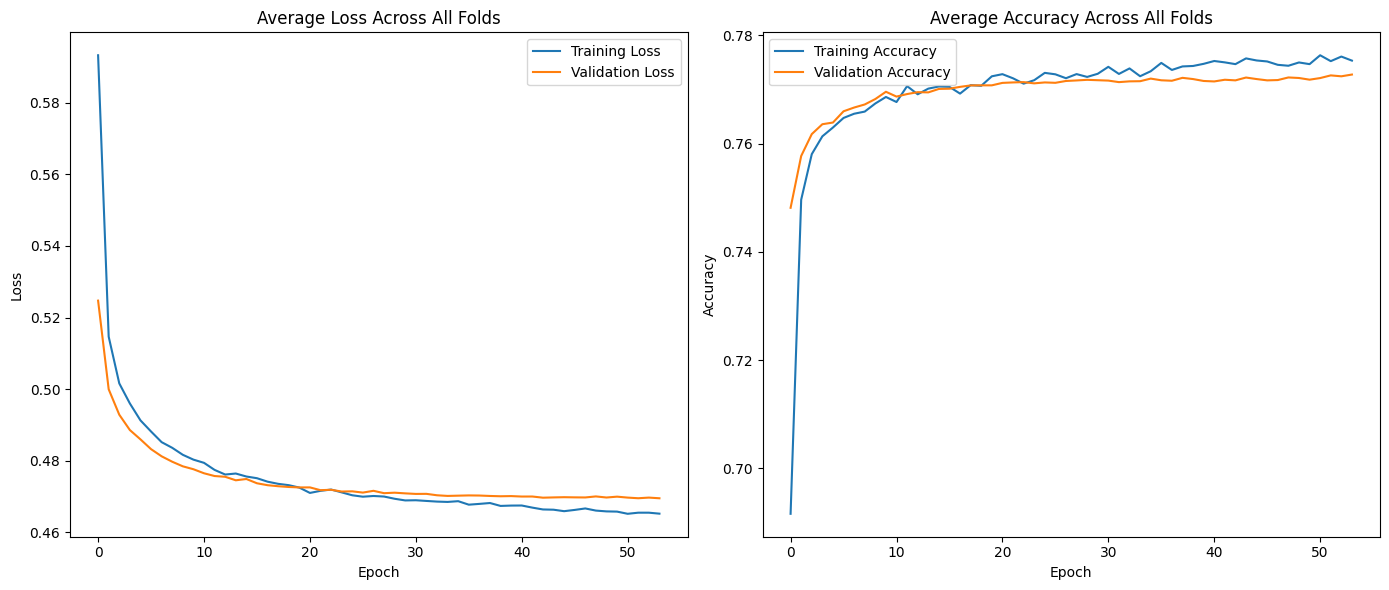

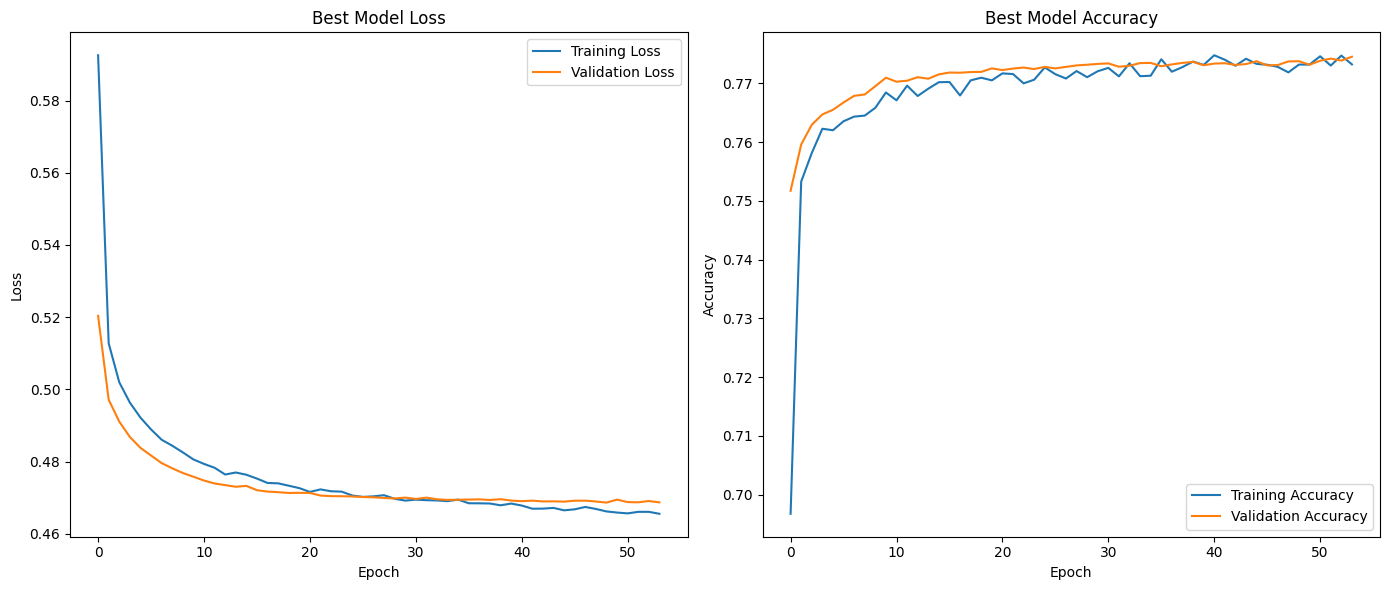


=== Final Results ===

Average Across All 2 Folds:
Accuracy: 0.7721 | Precision: 0.7551
Recall: 0.8054 | F1-Score: 0.7794

Best Model Performance (Fold 2 ):
              precision    recall  f1-score   support

Non Diabetes     0.7948    0.7375    0.7651     17656
    Diabetes     0.7556    0.8099    0.7818     17690

    accuracy                         0.7738     35346
   macro avg     0.7752    0.7737    0.7734     35346
weighted avg     0.7752    0.7738    0.7734     35346

Confusion Matrix:
[[13021  4635]
 [ 3362 14328]]

Best Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 32)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,508 (21.52 KB)

 Trainable params: 2,753 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,755 (10.77 KB)

In [3]:


# Define your model
def create_model():
    nn_model = Sequential()
    nn_model.add(Dense(32, input_shape=(num_features,), activation="relu"))
    nn_model.add(Dense(64, activation="relu"))
    nn_model.add(Dropout(0.2))
    nn_model.add(Dense(1, activation="sigmoid"))
    nn_model.compile(optimizer=RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
    return nn_model

# Early Stopping Callback
m_loss = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

# Initialize lists to store metrics and training histories
fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []
all_train_loss = []
all_val_loss = []
all_train_accuracy = []
all_val_accuracy = []

# K-Fold Cross-Validation
k = 2
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Variables to track the best model
best_val_accuracy = 0
best_model = None
best_history = None
best_fold = None

# Training loop
for fold_no, (train_index, val_index) in enumerate(kf.split(X), 1):
    print(f"\nTraining on fold {fold_no}...")
    
    # Split data
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Create and train the model
    model = create_model()
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=200,
        batch_size=32,
        callbacks=[m_loss],
        verbose=0
    )
    
    # Store training history
    all_train_loss.append(history.history['loss'])
    all_val_loss.append(history.history['val_loss'])
    all_train_accuracy.append(history.history['accuracy'])
    all_val_accuracy.append(history.history['val_accuracy'])
    
    # Evaluate and store metrics
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    y_pred = (model.predict(X_val) > 0.5).astype(int)
    
    fold_accuracies.append(val_accuracy)
    fold_precisions.append(precision_score(y_val, y_pred))
    fold_recalls.append(recall_score(y_val, y_pred))
    fold_f1_scores.append(f1_score(y_val, y_pred))
    
    # Track best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = model
        best_history = history.history
        best_fold = fold_no
        
        # Save best model and config
        best_model.save("dia_saved_models/dia_best_model_all.keras")
        dataset_config = {
            "best_fold": best_fold,
            "train_index": train_index,
            "val_index": val_index,
            "X_train": X_train,
            "X_val": X_val,
            "y_train": y_train,
            "y_val": y_val,
        }
        with open("dia_saved_models/dia_best_model_dataset_config_all.pkl", "wb") as f:
            pickle.dump(dataset_config, f)
        print(f"New best model found - Val Accuracy: {best_val_accuracy:.4f}")

# Calculate averages
avg_accuracy = np.mean(fold_accuracies)
avg_precision = np.mean(fold_precisions)
avg_recall = np.mean(fold_recalls)
avg_f1_score = np.mean(fold_f1_scores)

# Load best model and config
best_model = load_model("dia_saved_models/dia_best_model_all.keras")
with open("dia_saved_models/dia_best_model_dataset_config_all.pkl", "rb") as f:
    dataset_config = pickle.load(f)

# Generate classification report
y_pred = (best_model.predict(dataset_config["X_val"]) > 0.5).astype(int)
y_pred = np.squeeze(y_pred)

# ========== VISUALIZATIONS ==========

# Function to pad sequences to same length
def pad_sequences(sequences):
    max_len = max(len(seq) for seq in sequences)
    return np.array([seq + [seq[-1]]*(max_len-len(seq)) for seq in sequences])

# Pad all sequences
train_loss_padded = pad_sequences(all_train_loss)
val_loss_padded = pad_sequences(all_val_loss)
train_acc_padded = pad_sequences(all_train_accuracy)
val_acc_padded = pad_sequences(all_val_accuracy)

# Calculate averages
avg_train_loss = np.mean(train_loss_padded, axis=0)
avg_val_loss = np.mean(val_loss_padded, axis=0)
avg_train_acc = np.mean(train_acc_padded, axis=0)
avg_val_acc = np.mean(val_acc_padded, axis=0)

# FIGURE 1: Average Training Curves (2 subplots)
plt.figure(figsize=(14, 6))

# Subplot 1: Average Loss
plt.subplot(1, 2, 1)
plt.plot(avg_train_loss, label='Training Loss')
plt.plot(avg_val_loss, label='Validation Loss')
plt.title('Average Loss Across All Folds')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Subplot 2: Average Accuracy
plt.subplot(1, 2, 2)
plt.plot(avg_train_acc, label='Training Accuracy')
plt.plot(avg_val_acc, label='Validation Accuracy')
plt.title('Average Accuracy Across All Folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# FIGURE 2: Best Model Training Curves (2 subplots)
plt.figure(figsize=(14, 6))

# Subplot 1: Best Model Loss
plt.subplot(1, 2, 1)
plt.plot(best_history['loss'], label='Training Loss')
plt.plot(best_history['val_loss'], label='Validation Loss')
plt.title('Best Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Subplot 2: Best Model Accuracy
plt.subplot(1, 2, 2)
plt.plot(best_history['accuracy'], label='Training Accuracy')
plt.plot(best_history['val_accuracy'], label='Validation Accuracy')
plt.title('Best Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# ========== RESULTS SUMMARY ==========
print("\n=== Final Results ===")
print(f"\nAverage Across All {k} Folds:")
print(f"Accuracy: {avg_accuracy:.4f} | Precision: {avg_precision:.4f}")
print(f"Recall: {avg_recall:.4f} | F1-Score: {avg_f1_score:.4f}")

print("\nBest Model Performance (Fold", best_fold, "):")
print(classification_report(dataset_config["y_val"], y_pred, 
                          target_names=['Non Diabetes', 'Diabetes'],
                          digits=4))
print("Confusion Matrix:")
print(confusion_matrix(dataset_config["y_val"], y_pred))

print("\nBest Model Summary:")
best_model.summary()

# Store the dataset configuration into variables for later use
best_fold = dataset_config["best_fold"]
best_train_index = dataset_config["train_index"]
best_val_index = dataset_config["val_index"]
best_X_train = dataset_config["X_train"]
best_X_val = dataset_config["X_val"]
best_y_train = dataset_config["y_train"]
best_y_val = dataset_config["y_val"]

In [4]:
explainer_nn = shap.Explainer(best_model,best_X_train)
shap_values_nn = explainer_nn(best_X_val)

PermutationExplainer explainer: 35347it [19:51, 29.47it/s]                           


In [ ]:
# SAVING EXPLAINER
# Assuming 'explainer' is your SHAP explainer object
filename = 'dia_saved_models/dia_shap_explainer_all.bz2'
joblib.dump(explainer_nn, filename=filename, compress=('bz2', 3))

['dia_saved_models/dia_shap_explainer_all.bz2']

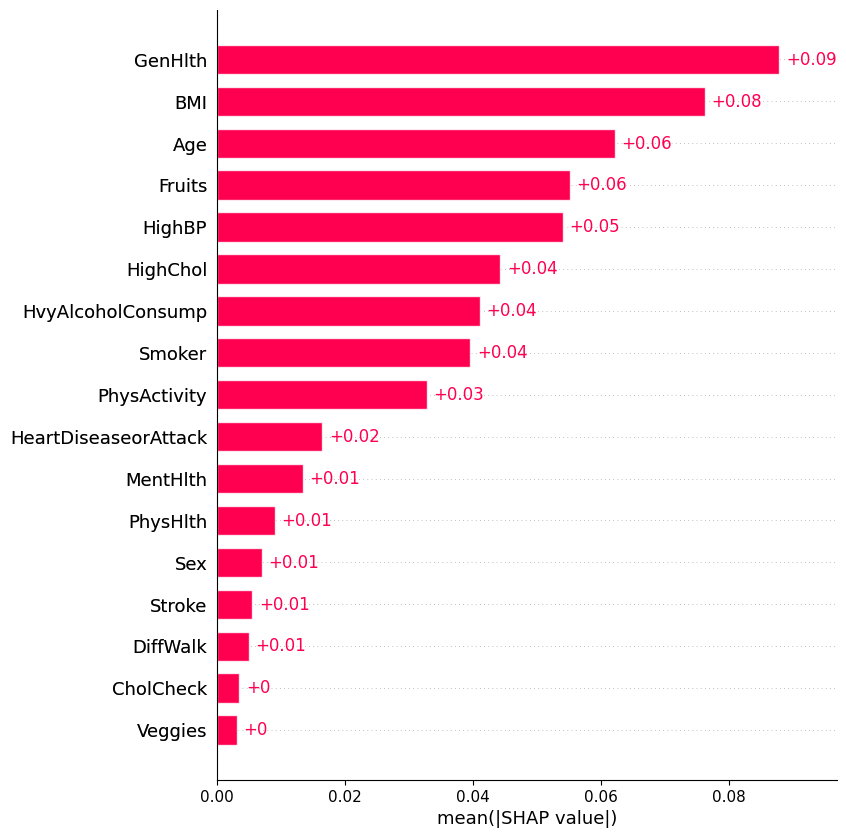

In [6]:
shap.plots.bar(shap_values_nn,max_display=20)

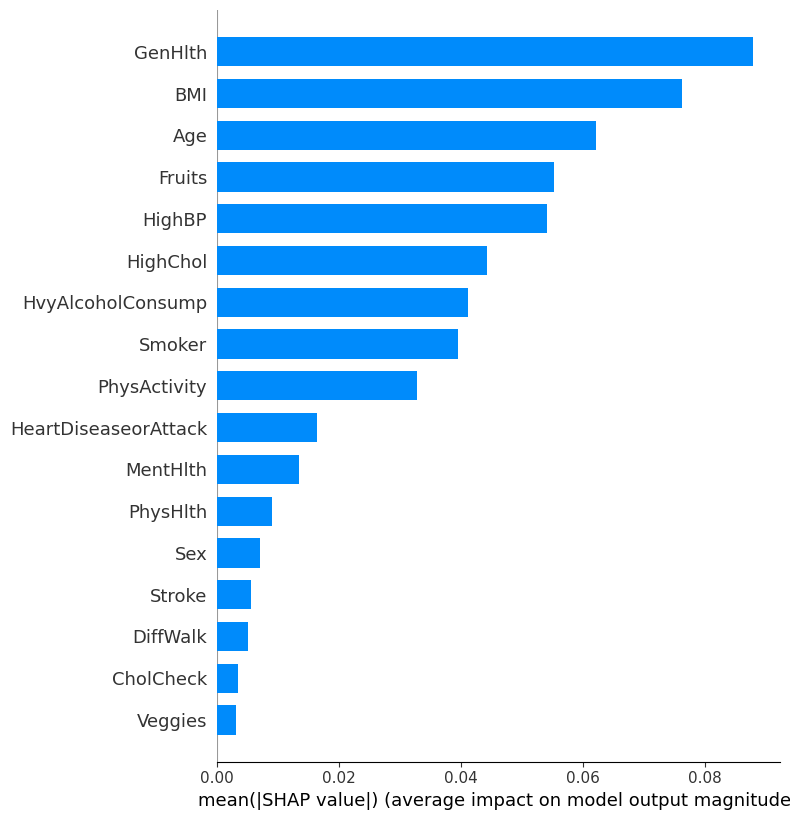

In [7]:
shap.summary_plot(shap_values_nn, best_X_val,plot_type="bar")


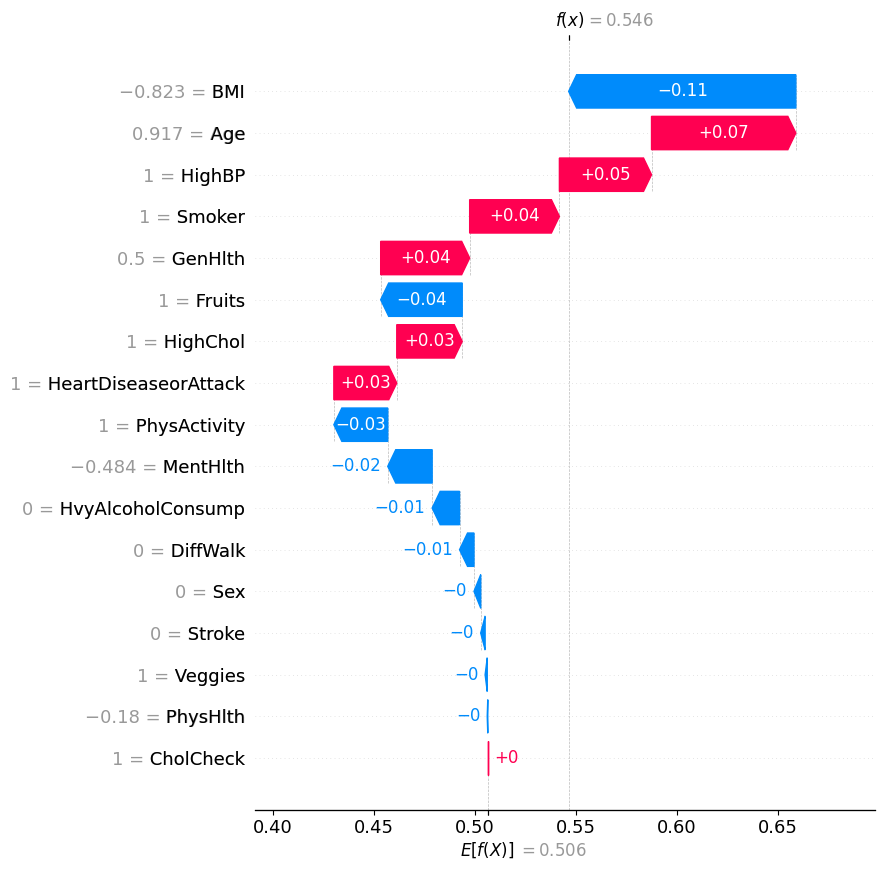

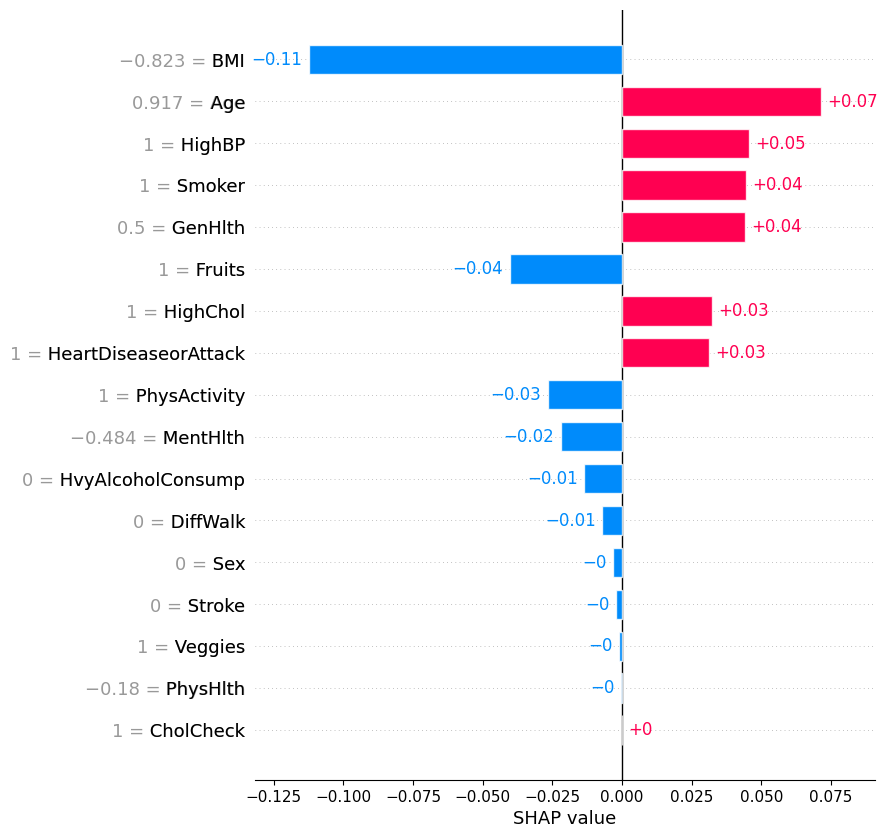

In [ ]:
instance_index = 3
# Get SHAP values for a specific instance from the SHAP explanation object
shap_values_for_instance_nn = shap_values_nn.values[instance_index]


shap.plots.waterfall(shap_values_nn[instance_index],max_display=20)
shap.plots.bar(shap_values_nn[instance_index],max_display=20)


In [11]:
best_X_val.iloc[instance_index]

Age                     0.916667
Sex                     0.000000
HighChol                1.000000
CholCheck               1.000000
BMI                    -0.823315
Smoker                  1.000000
HeartDiseaseorAttack    1.000000
PhysActivity            1.000000
Fruits                  1.000000
Veggies                 1.000000
HvyAlcoholConsump       0.000000
GenHlth                 0.500000
MentHlth               -0.484326
PhysHlth               -0.179923
DiffWalk                0.000000
Stroke                  0.000000
HighBP                  1.000000
Name: 10, dtype: float64

In [12]:
def predict_proba_wrapper(x):
    # Get the model's predictions (probability of class 1)
    prob_class_1 = best_model.predict(x, verbose=0)
    # Calculate probability of class 0
    prob_class_0 = 1 - prob_class_1
    # Stack the probabilities into a 2D array
    return np.hstack([prob_class_0, prob_class_1])

In [14]:
#explanation = explainer1.explain_instance(X_test.iloc[4],nn_model.predict,num_features=num_features,top_labels=1)
num_features = df.shape[1] - 1
features = list(df.columns[0:num_features])
print(features)
class_names = ['Non Diabetes','Diabetes']

index = 3


explainer1 = lime.lime_tabular.LimeTabularExplainer(best_X_train.values, feature_names=features, class_names=class_names, mode = 'classification', discretize_continuous=True)
explanation = explainer1.explain_instance(
    best_X_val.iloc[index], 
    predict_proba_wrapper,  # Use the wrapper function
    num_features=num_features, 
    top_labels=None
)
explanation.show_in_notebook(show_table=True, show_all=False)



['Age', 'Sex', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Stroke', 'HighBP']


/Users/martinkatona/Desktop/DP/.venv/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/martinkatona/Desktop/DP/.venv/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/martinkatona/Desktop/DP/.venv/lib/python3.10/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels 

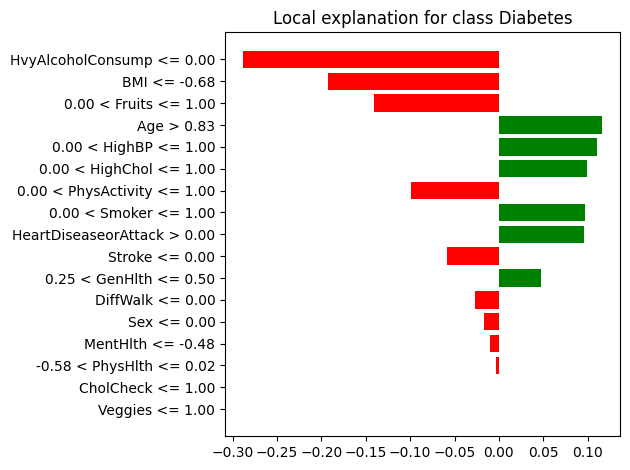

In [16]:
fig = explanation.as_pyplot_figure(label=1)
plt.tight_layout()
plt.show()